In [1]:
library(data.table)
library(ggplot2)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(ggsci)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::sec

## Load TF enrichment data

In [2]:
# Load cistarget TF motif enrichment for bulk ATAC-seq, cyto | belinostat and other comparisons
d = fread("/lustre/scratch126/cellgen/team205/is10/fibroblasts/bulk_cytokines/cistarget/enrichment_padj0.01/cistarget_res_df_NES0.1.txt")
#d = fread("/lustre/scratch126/cellgen/team205/is10/fibroblasts/bulk_cytokines/cistarget/enrichment_padj0.01/cistarget_res_df_NES3.0.txt")

colnames(d)[1] = "motif"

In [3]:
head(d)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
predrem__nrMotif404,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif404.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.834570,0.009876015,3258,33
predrem__nrMotif1203,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif1203.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.817860,0.009852666,11831,82
cisbp__M00569,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00569.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.567846,0.009503318,15087,90
jaspar__MA0249.2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0249.2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX",5.440159,0.009324900,4635,41
cisbp__M00127,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00127.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.324768,0.009163662,4357,34
flyfactorsurvey__CG16778_SANGER_5_FBgn0003715,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__CG16778_SANGER_5_FBgn0003715.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.279683,0.009100665,6091,56


In [3]:
colnames(d)

[1] "motif"           "Logo"            "Region_set"      "Direct_annot"   
[5] "Orthology_annot" "NES"             "AUC"             "Rank_at_max"    
[9] "Motif_hits"

In [4]:
table(d$Region_set)


differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down 
                                                                      3771 
  differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_up 
                                                                       868 
differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down 
                                                                      4213 
  differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_up 
                                                                      4243 
             differential_peak_table_FDR05_annotated_matched_Cytokine_down 
                                                                      4053 
               differential_peak_table_FDR05_annotated_matched_Cytokine_up 
                                                                      3872 

In [5]:
# Renamed region_set to short-hand format
d$Region_set_short = sapply(strsplit(d$Region_set, "_"), function(x) {
      paste0(x[7], "_", x[8])
})

## Load eRegulon enrichment scores from scRNA-seq data

In [6]:
# Load eRegulons specificity scores by fibroblast cell type
cell_rss = fread("../scenic+_patrick/data/RSS/RSS_scores_filtered.csv")

# format
cell_rss = as.data.frame(cell_rss)
rownames(cell_rss) = cell_rss[, 1]
cell_rss = cell_rss[, -1]

In [7]:
dim(cell_rss)

[1]  8 60

In [9]:
cell_rss

,FOSL1_+_(1766r),ZNF91_+_(69r),REL_+_(1041r),CEBPB_+_(473r),BATF3_+_(1684r),ZNF652_+_(54r),ETV7_+_(2208r),ATF5_+_(105r),RUNX2_+_(55r),CEBPA_+_(261r),⋯,ZNF676_+_(115r),ETV1_+_(2204r),SATB1_+_(188r),ETS2_+_(2444r),CREB5_+_(96r),EBF1_+_(305r),ZNF783_+_(90r),ETS1_+_(3833r),ZNF281_+_(1540r),MAFK_+_(2150r)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S5,0.4334689,0.2248862,0.3695923,0.3205521,0.3923933,0.4649429,0.3891464,0.3364527,0.5344206,0.2788616,⋯,0.2307494,0.3020085,0.2740919,0.3273537,0.2581714,0.2103988,0.2341911,0.3531035,0.3426820,0.3256514
S3x,0.2452355,0.1674454,0.2672309,0.2567768,0.2489803,0.2446594,0.2806955,0.4218007,0.1674454,0.3345779,⋯,0.3120446,0.2486327,0.2520111,0.2080382,0.4466567,0.3054889,0.1789018,0.2377385,0.2330776,0.2661203
S3,0.3021269,0.2077519,0.3472653,0.2995408,0.2837605,0.2283628,0.3054309,0.2685467,0.1808205,0.3771986,⋯,0.4259360,0.2805090,0.2847555,0.2570634,0.2163098,0.3606012,0.2580509,0.2816112,0.2775101,0.2958773
S1,0.3162577,0.3221747,0.3146802,0.3641594,0.3454327,0.3246474,0.2943162,0.1952965,0.1679923,0.3037143,⋯,0.3754714,0.3500078,0.2887780,0.3735775,0.2057302,0.2810183,0.3477496,0.3458522,0.3514764,0.3471725
PC,0.2051665,0.1719293,0.2055095,0.1922258,0.2260915,0.1765048,0.2300964,0.1879674,0.2075843,0.1876861,⋯,0.2176803,0.2280422,0.2110793,0.2218994,0.1816227,0.3662578,0.2727756,0.2478219,0.2108156,0.2419608
MF1,0.1805440,0.1988629,0.1812449,0.1877443,0.1933576,0.1697658,0.1808882,0.1683785,0.1674454,0.1920728,⋯,0.2134403,0.1923251,0.1891030,0.1945664,0.1839783,0.1823401,0.2222995,0.1957905,0.1895296,0.2000126
S4,0.1874173,0.2591103,0.2003427,0.1823061,0.1868080,0.1674454,0.1907950,0.1744431,0.1748939,0.2029745,⋯,0.2105435,0.1809665,0.1787906,0.1846835,0.1674454,0.2090323,0.1971883,0.1865007,0.1925391,0.1846982
S2,0.2377621,0.4023306,0.2442791,0.2788116,0.2741031,0.2539510,0.2593572,0.2012527,0.1674454,0.1809260,⋯,0.2250962,0.3637870,0.3272528,0.3524029,0.2146060,0.1777655,0.2798181,0.3122407,0.3126082,0.3115114


## Joint analysis of TF enrichment and eRegulon specifcity

In [8]:
# Expand motif annotation data for multiple possibilities
head(d)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
predrem__nrMotif404,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif404.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.834570,0.009876015,3258,33,Cytokine_up
predrem__nrMotif1203,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif1203.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.817860,0.009852666,11831,82,Cytokine_up
cisbp__M00569,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00569.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.567846,0.009503318,15087,90,Cytokine_up
jaspar__MA0249.2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0249.2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX",5.440159,0.009324900,4635,41,Cytokine_up
cisbp__M00127,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00127.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.324768,0.009163662,4357,34,Cytokine_up
flyfactorsurvey__CG16778_SANGER_5_FBgn0003715,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__CG16778_SANGER_5_FBgn0003715.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.279683,0.009100665,6091,56,Cytokine_up


### Split eRegulon data by inividual TF annotations

In [9]:
# Combine Direct and Orthology annotation
d$annot = paste0(d$Direct_annot, d$Orthology_annot, ",")
d$annot[d$annot == ","] = NA

# Count number of TFs annotated, which are used for separating into parsing separate rows per predicted TF
counts = sapply(d$annot, function(str) {
    length(strsplit(str, ",")[[1]])
})

# Split TF annotations to separate rows
# Filters out motifs without TF annotation
d_split = d %>% 
    separate(annot, into=paste0("v", 1:max(counts)), sep=",") %>%
    gather(key="key", value = "annot", starts_with("v"), na.rm = TRUE) %>%
    select(-key)

Warning message:
“Expected 65 pieces. Additional pieces discarded in 2 rows [5107, 13546].”
Warning message:
“Expected 65 pieces. Missing pieces filled with `NA` in 8218 rows [4, 7, 8, 10,
13, 26, 27, 31, 36, 38, 42, 43, 45, 46, 49, 51, 54, 56, 57, 59, ...].”


In [10]:
dim(d_split)

[1] 28719    11

In [11]:
#head(d_split)

In [12]:
# options(repr.plot.width = 12, repr.plot.height = 6)

# ggplot(d_split, aes(x=Motif_hits, y=NES, col=Region_set)) +
#     geom_point() +
#     theme_minimal()

### Merge eRegulon data with TF motif enrichment

In [13]:
colnames(cell_rss)

[1] "FOSL1_+_(1766r)"       "ZNF91_+_(69r)"         "REL_+_(1041r)"        
 [4] "CEBPB_+_(473r)"        "BATF3_+_(1684r)"       "ZNF652_+_(54r)"       
 [7] "ETV7_+_(2208r)"        "ATF5_+_(105r)"         "RUNX2_+_(55r)"        
[10] "CEBPA_+_(261r)"        "KLF12_+_(249r)"        "FOXO1_+_(1034r)"      
[13] "RARG_+_(76r)"          "NR1H4_+_(16r)"         "FOXF2_+_(551r)"       
[16] "KLF2_+_(1596r)"        "PBX1_extended_+_(62r)" "BCL6_+_(53r)"         
[19] "ETV5_+_(3199r)"        "TCF21_+_(530r)"        "RELB_+_(1025r)"       
[22] "PBX3_+_(59r)"          "FOXL1_+_(574r)"        "ZNF570_+_(20r)"       
[25] "ZNF644_+_(98r)"        "SOX5_+_(296r)"         "HOXB2_+_(108r)"       
[28] "FOXJ3_+_(265r)"        "ZNF626_+_(47r)"        "MSC_+_(325r)"         
[31] "FOXQ1_+_(188r)"        "IRF9_+_(15r)"          "FOXF1_+_(528r)"       
[34] "ZNF571_+_(523r)"       "MEF2D_+_(567r)"        "FOXC2_+_(46r)"        
[37] "IKZF2_+_(144r)"        "EBF3_+_(128r)"         "ZNF770_+_(250r)"      
[40] "ELK1_+_(3611r)"        "ETV4_+_(849r)"         "NR3C1_+_(336r)"       
[43] "MECP2_+_(43r)"         "MEF2C_+_(744r)"        "STAT4_+_(32r)"        
[46] "PRDM1_+_(27r)"         "DRAP1_+_(80r)"         "ZNF680_+_(17r)"       
[49] "NFYC_+_(48r)"          "ARID3A_+_(829r)"       "ZNF676_+_(115r)"      
[52] "ETV1_+_(2204r)"        "SATB1_+_(188r)"        "ETS2_+_(2444r)"       
[55] "CREB5_+_(96r)"         "EBF1_+_(305r)"         "ZNF783_+_(90r)"       
[58] "ETS1_+_(3833r)"        "ZNF281_+_(1540r)"      "MAFK_+_(2150r)"

In [14]:
# Long format of eRegulon specificity scores
cell_rss_long = melt(as.matrix(cell_rss), value.name = "RSS")

colnames(cell_rss_long)[1] = "cell_type"
colnames(cell_rss_long)[2] = "regulon"

In [15]:
# Strip region info and +/- from colum names
cell_rss_long$annot = sapply(strsplit(as.character(cell_rss_long$regulon), "_"), function(x) x[1])

In [16]:
#head(cell_rss_long)

In [17]:
# Combine RSS eRegulon from single-cell data with bulk ATAC-seq TF motif enrichment data
d_rss_merge = merge(d_split, cell_rss_long, by = "annot")
head(d_rss_merge)

,annot,motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,cell_type,regulon,RSS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>
1,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,S1,ARID3A_+_(829r),0.3458177
2,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,S2,ARID3A_+_(829r),0.2944819
3,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,PC,ARID3A_+_(829r),0.2280776
4,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,S5,ARID3A_+_(829r),0.3552807
5,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,S4,ARID3A_+_(829r),0.1906648
6,ARID3A,swissregulon__hs__ARID3A,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/swissregulon__hs__ARID3A.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat_down,ARID3A,,1.865249,0.008050291,16226,10100,Cytokine + Belinostat_down,S3x,ARID3A_+_(829r),0.2478286


In [46]:
write_csv(d_rss_merge, "data/bulk_sc_merge_cistarget_scenic.csv")

## Visualization

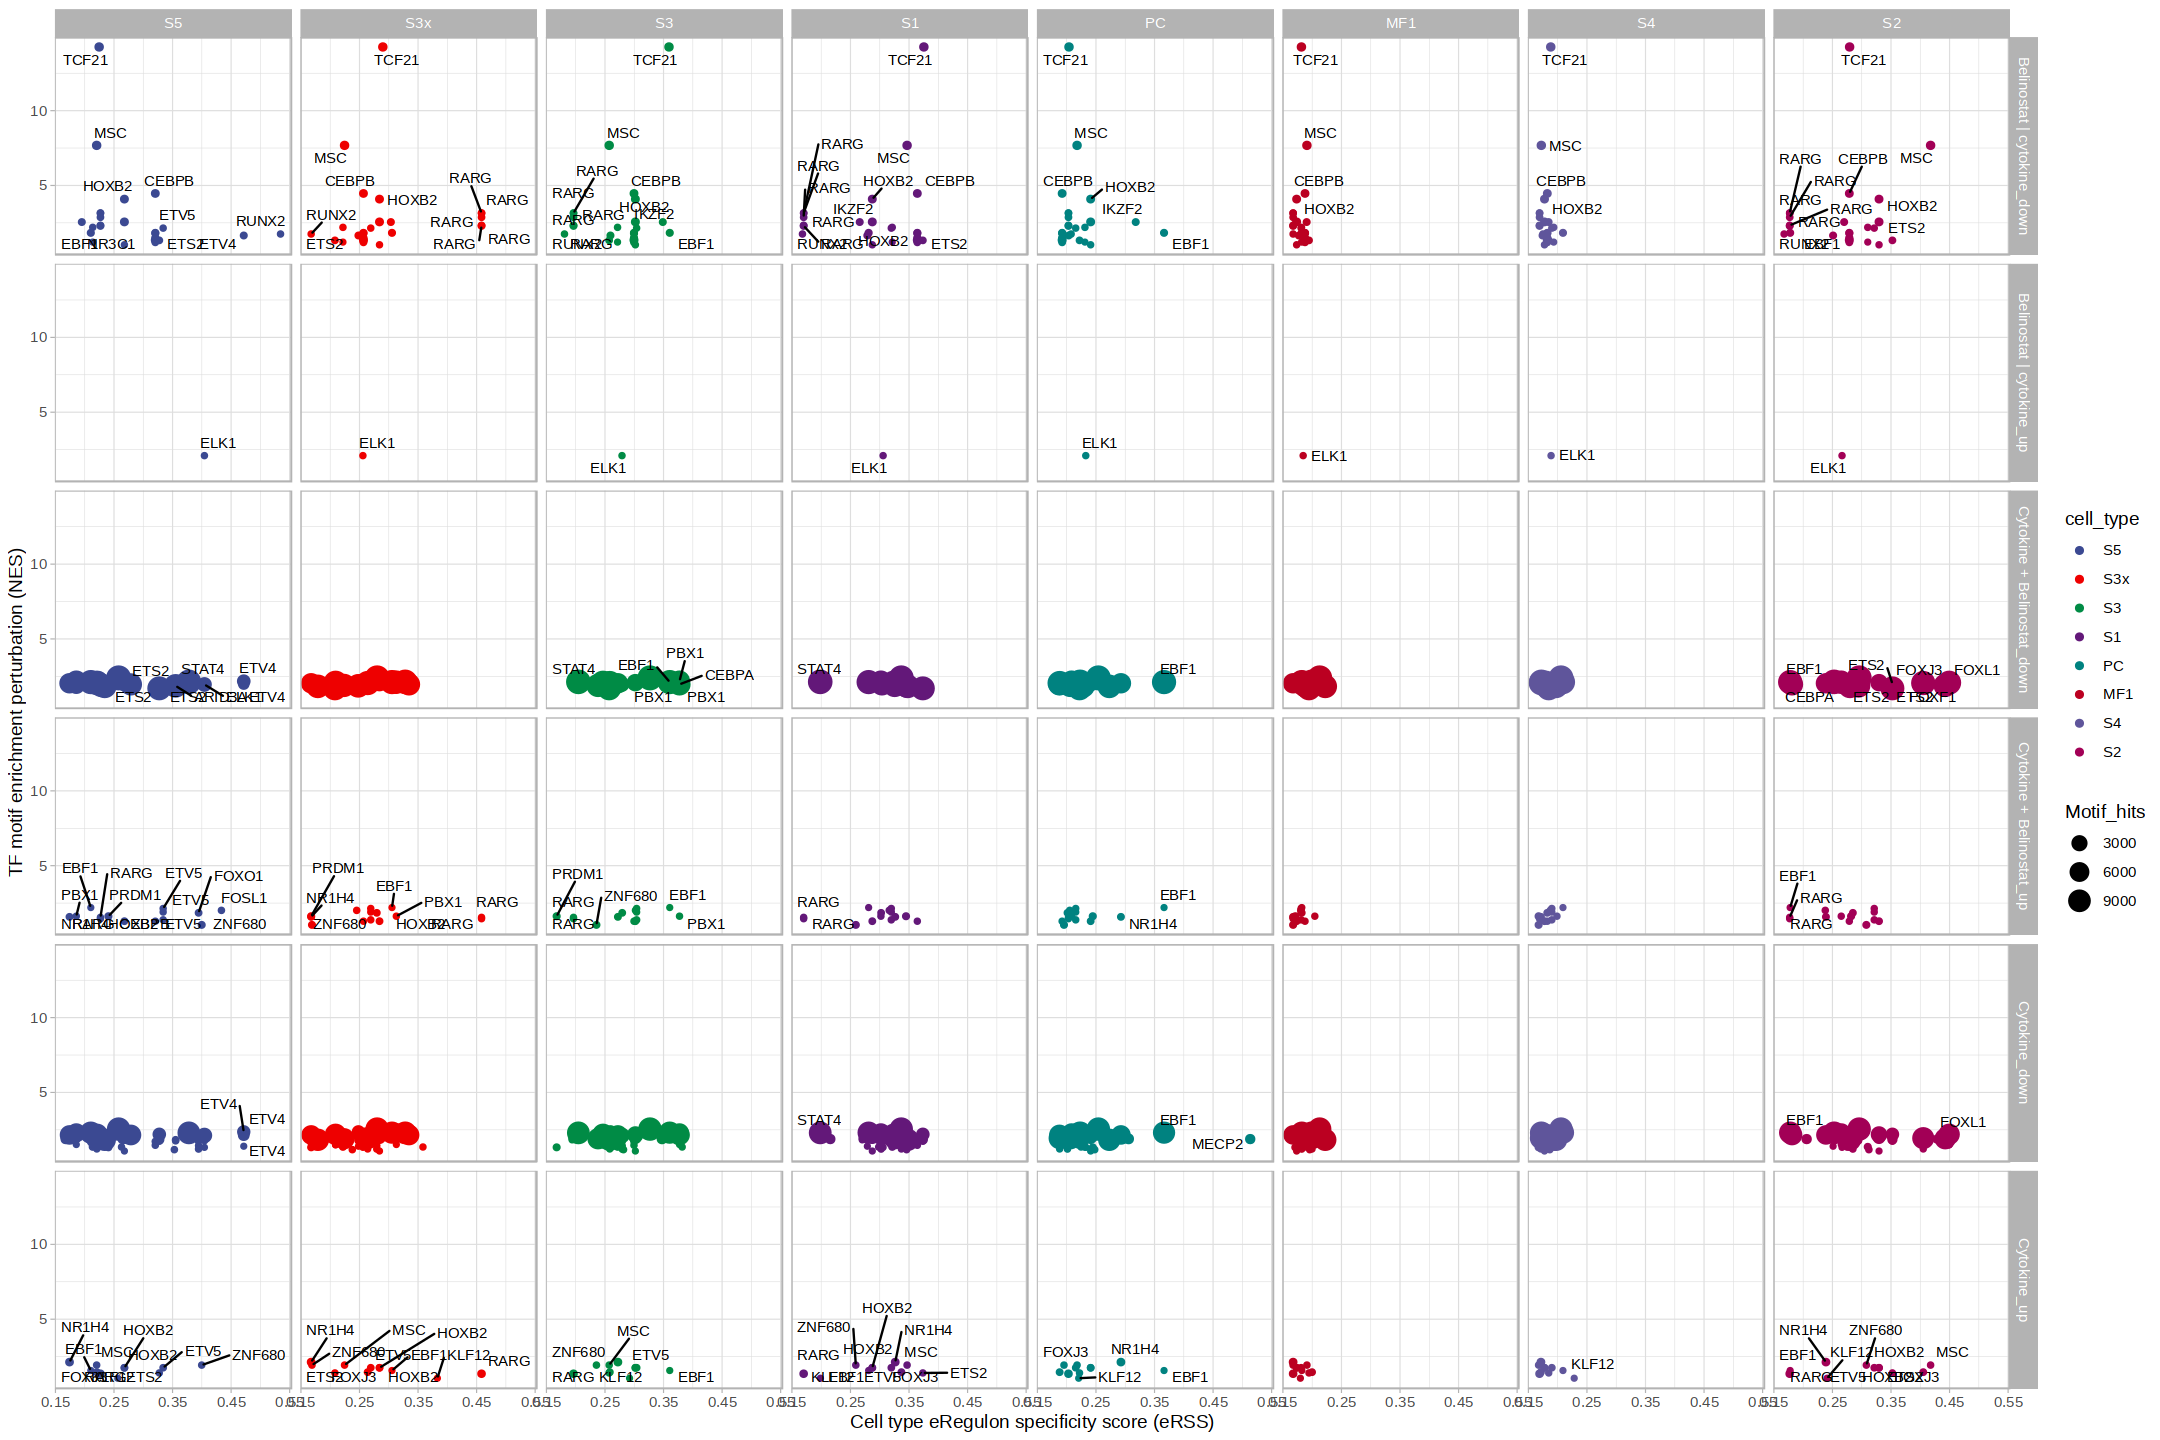

In [18]:
width = 18; height = 12

options(repr.plot.width = width, repr.plot.height = height)
options(warn=-1)  # supress all warnings, in particular from ggrepel overlapping labels


ggplot(
    d_rss_merge[d_rss_merge$Motif_hits >= 3 & d_rss_merge$NES > 1, ],
    #d_rss_merge,
       aes(x=RSS, y=NES, color=cell_type, size=Motif_hits)) +
    xlab("Cell type eRegulon specificity score (eRSS)") +
    ylab("TF motif enrichment perturbation (NES)") +
    facet_grid(Region_set_short~cell_type) +
    geom_point() +
    geom_text_repel(aes(label = annot), size=3, color="black", max.overlaps=16) +
    scale_color_aaas() +
    theme_light()

ggsave("plots/bulkATAC_scATAC_motif_enrichment_comparison.pdf", width = width, height=height)

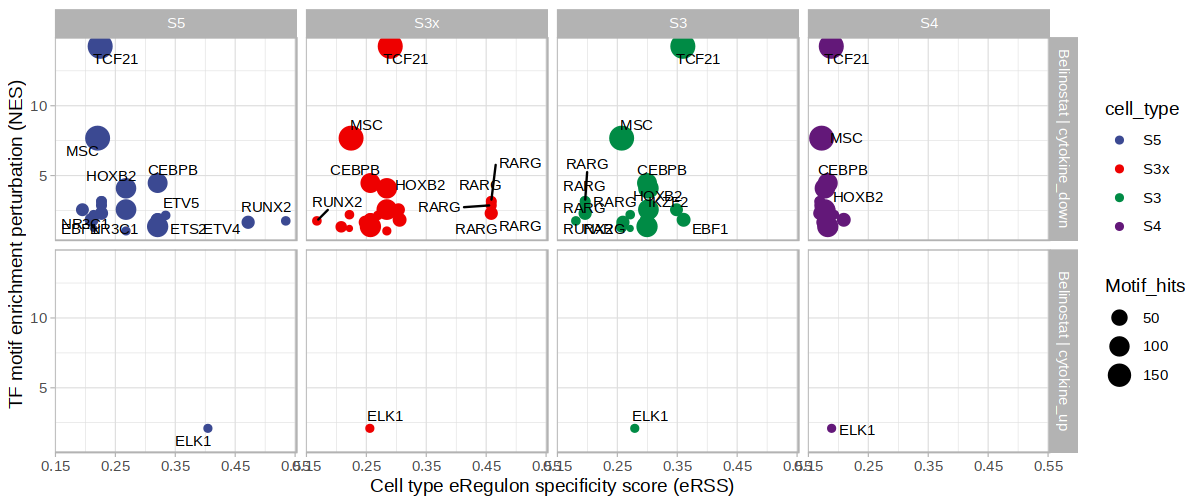

In [39]:
width = 10; height = 4.2

options(repr.plot.width = width, repr.plot.height = height)

ggplot(
    d_rss_merge[d_rss_merge$Motif_hits >= 3 &
                d_rss_merge$NES > 1 &
                d_rss_merge$cell_type %in% c("S5", "S3", "S3x", "S4") &
                d_rss_merge$Region_set_short %in% c("Belinostat | cytokine_down", "Belinostat | cytokine_up"), ],
    #d_rss_merge,
       aes(x=RSS, y=NES, color=cell_type, size=Motif_hits)) +
    xlab("Cell type eRegulon specificity score (eRSS)") +
    ylab("TF motif enrichment perturbation (NES)") +
    facet_grid(Region_set_short~cell_type) +
    geom_point() +
    geom_text_repel(aes(label = annot), size=3, color="black", max.overlaps=16) +
    scale_color_aaas() +
    theme_light()

ggsave("plots/bulkATAC_scATAC_motif_enrichment_comparison_subset.pdf", width = width, height=height)

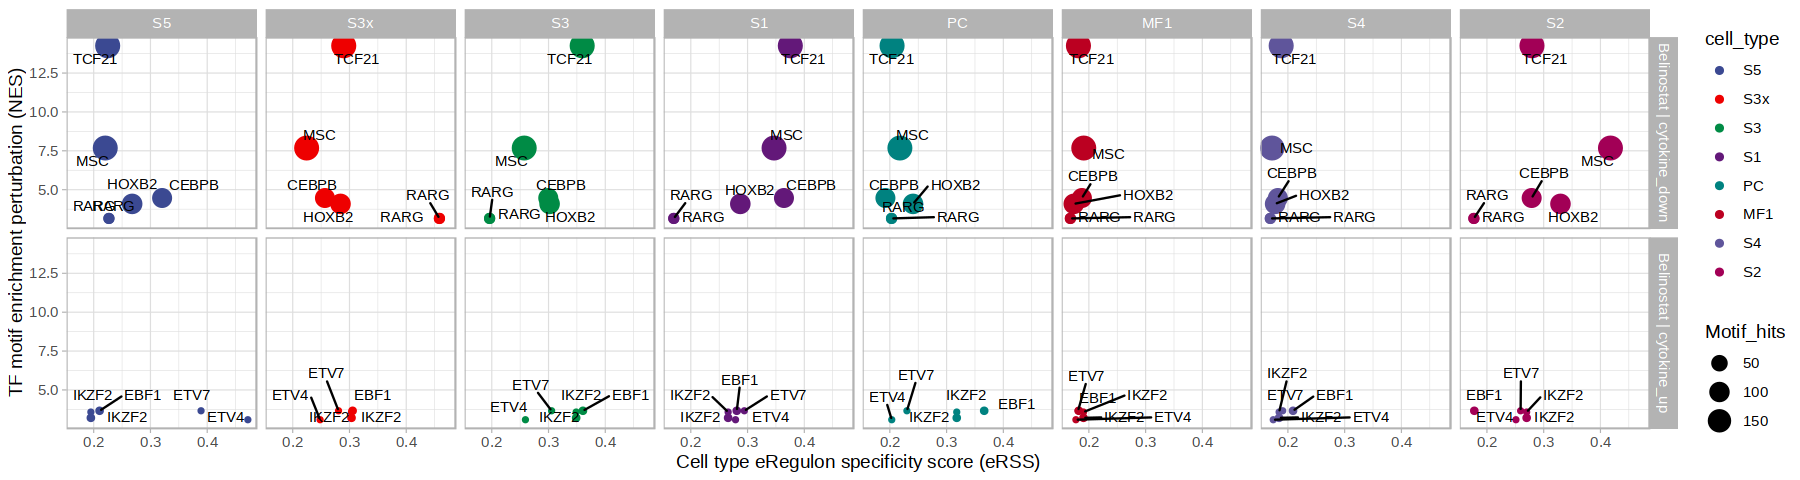

In [40]:
options(repr.plot.width = 15, repr.plot.height = 4)

ggplot(
    d_rss_merge[d_rss_merge$Motif_hits >= 0 & d_rss_merge$NES > 3, ],
    #d_rss_merge,
       aes(x=RSS, y=NES, color=cell_type, size=Motif_hits)) +
    xlab("Cell type eRegulon specificity score (eRSS)") +
    ylab("TF motif enrichment perturbation (NES)") +
    facet_grid(Region_set_short~cell_type) +
    geom_point() +
    geom_text_repel(aes(label = annot), size=3, color="black", max.overlaps=16) +
    scale_color_aaas() +
    theme_light()

In [24]:
#d_rss_merge

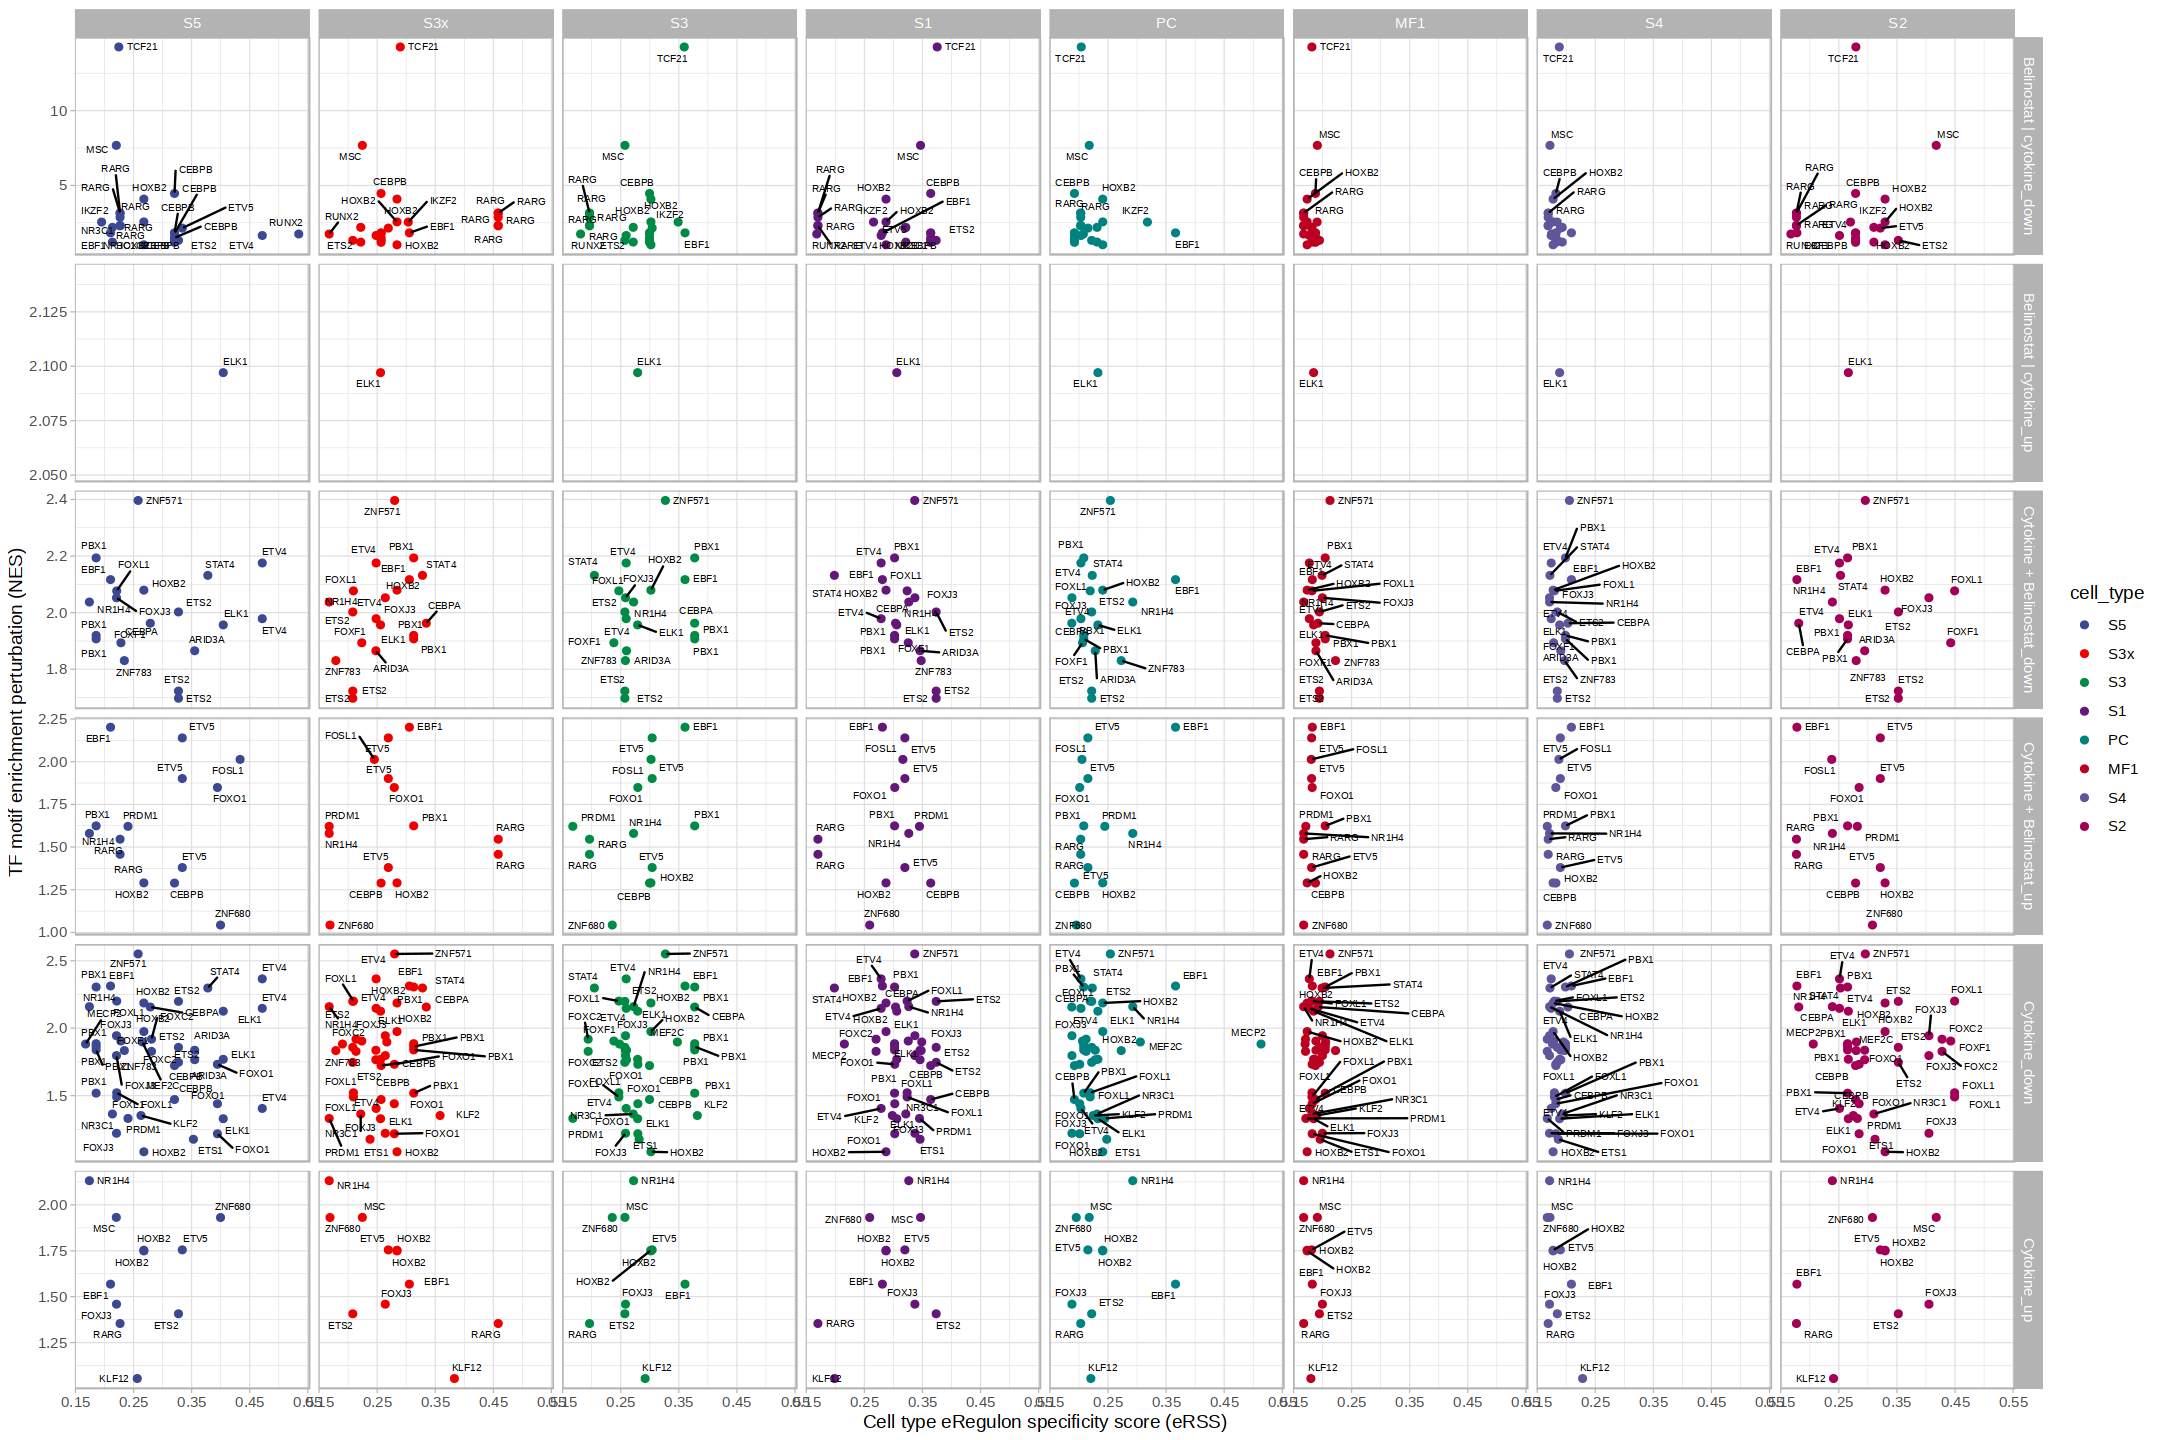

In [25]:
width = 18; height = 12

options(repr.plot.width = width, repr.plot.height = height)
options(warn=-1)  # supress all warnings, in particular from ggrepel overlapping labels

ggplot(
    d_rss_merge[d_rss_merge$Motif_hits >= 3 & d_rss_merge$NES > 1, ],
    #d_rss_merge,
       aes(x=RSS, y=NES, color=cell_type)) +
    xlab("Cell type eRegulon specificity score (eRSS)") +
    ylab("TF motif enrichment perturbation (NES)") +
    facet_grid(Region_set_short~cell_type, scales="free_y") +
    geom_point() +
    geom_text_repel(aes(label = annot), size=2, color="black", max.overlaps=16) +
    scale_color_aaas() +
    theme_light()

ggsave("plots/bulkATAC_scATAC_motif_enrichment_comparison_v2.pdf", width = width, height=height)

In [41]:
options(repr.matrix.max.rows=600)
#d_rss_merge[d_rss_merge$annot == "CEBPB", ]

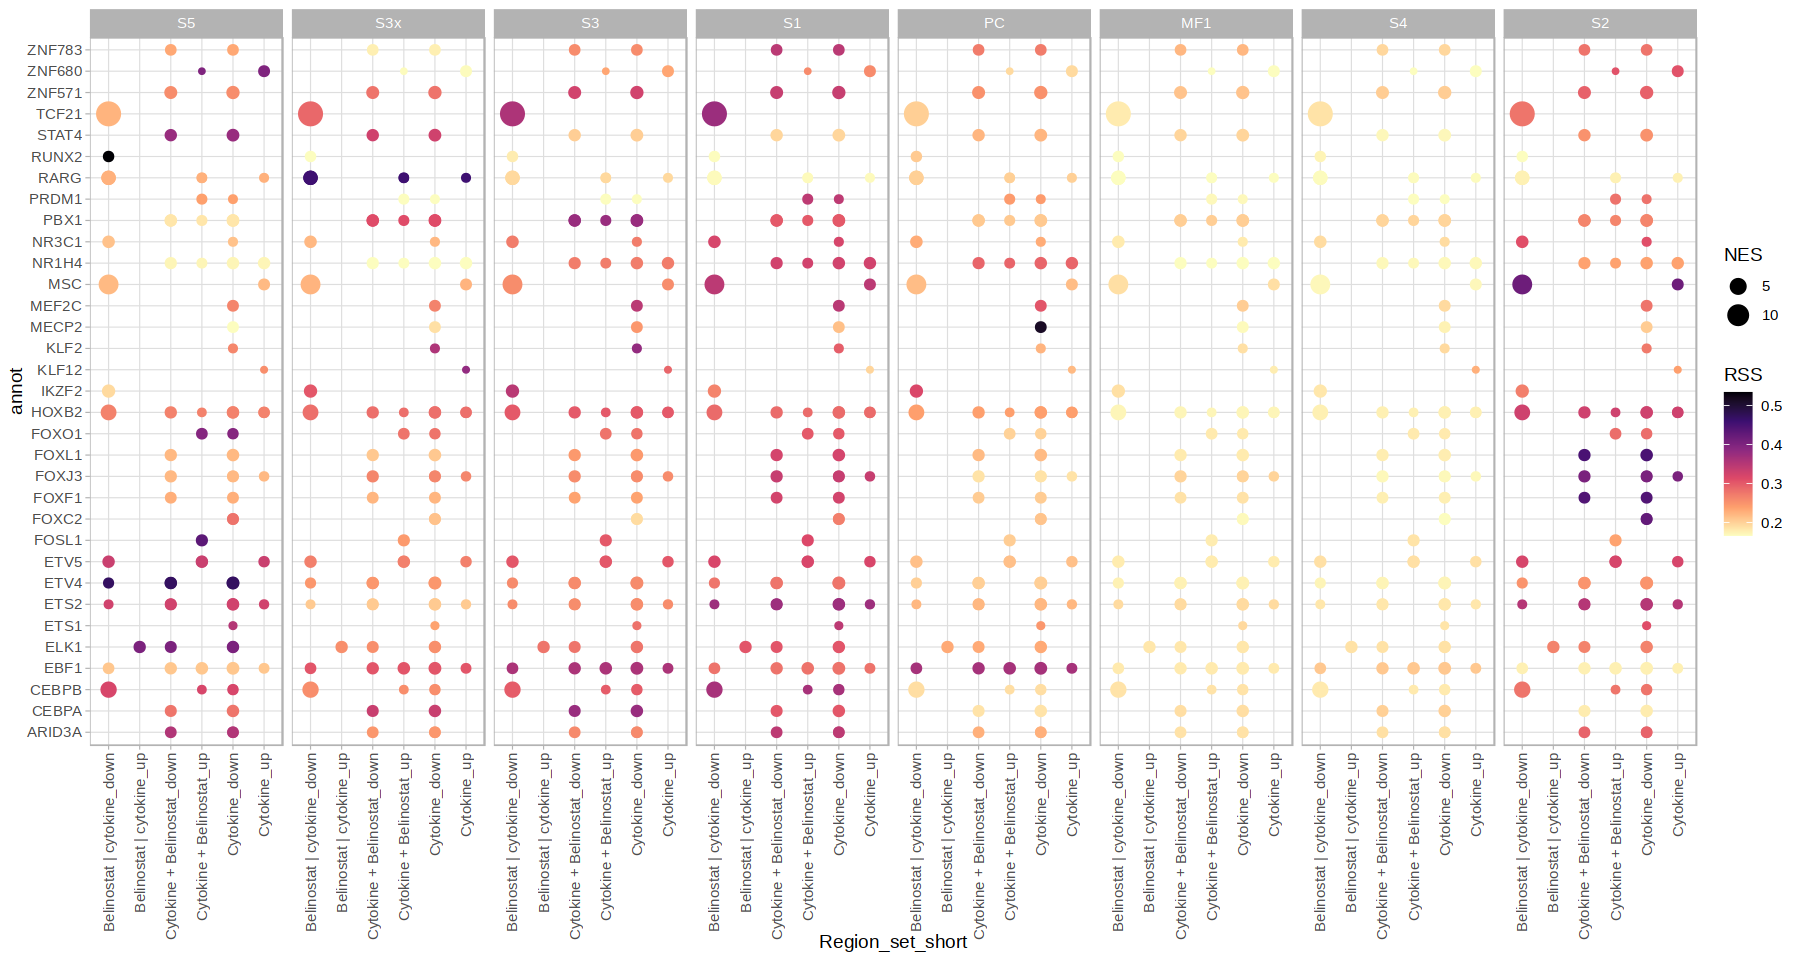

In [42]:
options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(
    d_rss_merge[d_rss_merge$Motif_hits >= 3 & d_rss_merge$NES > 1, ],
    #d_rss_merge,
       aes(x=Region_set_short, y=annot, color=RSS, size=NES)) +
    #xlab("Cell type eRegulon specificity score (eRSS)") +
    #ylab("TF motif enrichment perturbation (NES)") +
    facet_grid(~cell_type) +
    geom_point() +
    scale_color_viridis_c(option="magma", direction=-1) +
    theme_light() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


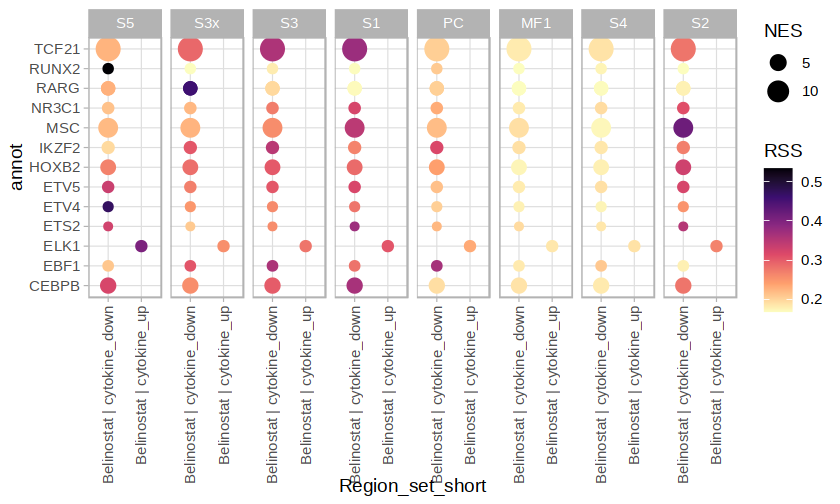

In [43]:
width = 7; height = 4.2
options(repr.plot.width = width, repr.plot.height = height)

ggplot(
    d_rss_merge[
        d_rss_merge$Motif_hits >= 3 &
        d_rss_merge$NES > 1 &
        d_rss_merge$Region_set_short %in% c("Belinostat | cytokine_down", "Belinostat | cytokine_up"), ],
    #d_rss_merge,
       aes(x=Region_set_short, y=annot, color=RSS, size=NES)) +
    facet_grid(~cell_type) +
    geom_point() +
    scale_color_viridis_c(option="magma", direction=-1) +
    theme_light() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggsave("plots/bulkATAC_scATAC_motif_enrichment_comparison_dotplot.pdf", width = width, height=height)

In [68]:
# d_rss_merge[
#         d_rss_merge$Motif_hits >= 3 &
#         d_rss_merge$NES > 1 &
#         d_rss_merge$Region_set_short %in% c("Belinostat | cytokine_down", "Belinostat | cytokine_up"), ]

In [50]:
head(d)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,annot
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
predrem__nrMotif404,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif404.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.834570,0.009876015,3258,33,Cytokine_up,NA
predrem__nrMotif1203,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif1203.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.817860,0.009852666,11831,82,Cytokine_up,NA
cisbp__M00569,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00569.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.567846,0.009503318,15087,90,Cytokine_up,NA
jaspar__MA0249.2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0249.2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX",5.440159,0.009324900,4635,41,Cytokine_up,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX,"
cisbp__M00127,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00127.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.324768,0.009163662,4357,34,Cytokine_up,NA
flyfactorsurvey__CG16778_SANGER_5_FBgn0003715,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__CG16778_SANGER_5_FBgn0003715.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.279683,0.009100665,6091,56,Cytokine_up,NA


In [132]:
#table(d$Region_set_short)

In [131]:
#head(d_rss_merge)

In [138]:
head(d)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,annot
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
predrem__nrMotif404,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif404.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.834570,0.009876015,3258,33,Cytokine_up,NA
predrem__nrMotif1203,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif1203.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.817860,0.009852666,11831,82,Cytokine_up,NA
cisbp__M00569,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00569.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.567846,0.009503318,15087,90,Cytokine_up,NA
jaspar__MA0249.2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0249.2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX",5.440159,0.009324900,4635,41,Cytokine_up,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX,"
cisbp__M00127,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00127.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.324768,0.009163662,4357,34,Cytokine_up,NA
flyfactorsurvey__CG16778_SANGER_5_FBgn0003715,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__CG16778_SANGER_5_FBgn0003715.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.279683,0.009100665,6091,56,Cytokine_up,NA


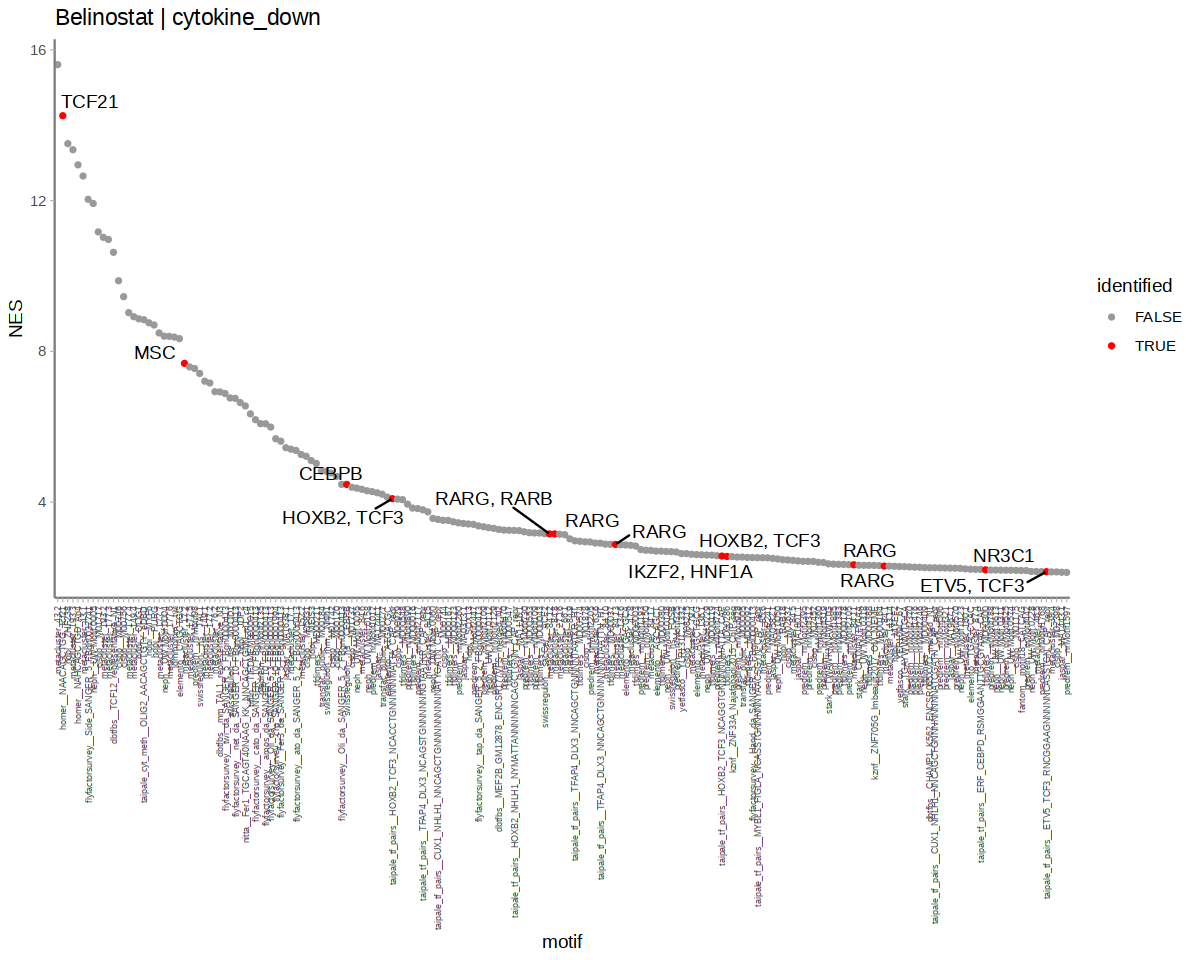

In [143]:
width = 10; height = 8

options(repr.plot.width = width, repr.plot.height = height)

d_sub = d[d$Region_set_short == "Belinostat | cytokine_down",]

d_sub$identified = FALSE
d_sub$identified[d_sub$motif %in% d_rss_merge$motif] = TRUE

d_sub = d_sub[order(d_sub$NES, decreasing=TRUE), ]
d_sub$motif = factor(d_sub$motif, levels=d_sub$motif)


d_sub$label = paste0(d_sub$Direct_annot, ",", d_sub$Orthology_annot)

d_sub$label = trimws(d_sub$label, whitespace=",")  # trim additional commas

d_sub$label[!d_sub$identified] = ""  #hide labels

d_sub = d_sub[1:200, ]


ggplot(d_sub,
    aes(x=motif, y=NES, color=identified)) +
    ggtitle("Belinostat | cytokine_down") +
    geom_point(size=1) + 
    geom_text_repel(aes(label=label), color="black", max.overlaps=Inf) +
    scale_color_manual(values=c("grey60", "red")) +
    theme_light() +
    # rotate x labels
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=5)) +
    # No gridline
    theme(
        axis.line = element_line(colour = "grey50"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        #panel.background = element_blank()
    ) 

ggsave("plots/bulkATAC_motif_ranking_Belinostat | cytokine_down.pdf", width = width, height=height)    

In [64]:
head(d_sub)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,annot
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
tfdimers__MD00039,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/tfdimers__MD00039.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,"GATA1, GATA2, GATA5, GATA4, GATA3, GATA6",,0.1001706,0.003301530,0,0,Belinostat | cytokine_down,"GATA1, GATA2, GATA5, GATA4, GATA3, GATA6,"
metacluster_51.23,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_51.23.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,MEOX1,,0.1001706,0.003301530,0,0,Belinostat | cytokine_down,"MEOX1,"
taipale_tf_pairs__FOXJ2_PITX1_NTAATCCNNWMAACA_CAP_repr,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/taipale_tf_pairs__FOXJ2_PITX1_NTAATCCNNWMAACA_CAP_repr.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,"FOXJ2, PITX1",,0.1004652,0.003302371,0,0,Belinostat | cytokine_down,"FOXJ2, PITX1,"
cisbp__M01847,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M01847.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,,,0.1007598,0.003303212,0,0,Belinostat | cytokine_down,NA
taipale_tf_pairs__SOX6_CACCGAACAAT_HT,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/taipale_tf_pairs__SOX6_CACCGAACAAT_HT.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,SOX6,,0.1007598,0.003303212,0,0,Belinostat | cytokine_down,"SOX6,"
cisbp__M07340,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M07340.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine_down,,,0.1010545,0.003304054,72,1,Belinostat | cytokine_down,NA


In [145]:
head(d)

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,annot
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
predrem__nrMotif404,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif404.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.834570,0.009876015,3258,33,Cytokine_up,NA
predrem__nrMotif1203,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/predrem__nrMotif1203.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.817860,0.009852666,11831,82,Cytokine_up,NA
cisbp__M00569,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00569.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.567846,0.009503318,15087,90,Cytokine_up,NA
jaspar__MA0249.2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0249.2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX",5.440159,0.009324900,4635,41,Cytokine_up,"TCF15, FERD3L, TCF21, TCF23, FIGLA, TWIST1, TCF24, HAND2, TWIST2, MSC, BHLHA9, HAND1, SCX,"
cisbp__M00127,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/cisbp__M00127.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.324768,0.009163662,4357,34,Cytokine_up,NA
flyfactorsurvey__CG16778_SANGER_5_FBgn0003715,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__CG16778_SANGER_5_FBgn0003715.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,,5.279683,0.009100665,6091,56,Cytokine_up,NA


In [150]:
d[grepl("RELB", d$annot), ]

motif,Logo,Region_set,Direct_annot,Orthology_annot,NES,AUC,Rank_at_max,Motif_hits,Region_set_short,annot
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
bergman__dl-B,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/bergman__dl-B.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"RELA, RELB, REL, NFKB2, NFKB1",0.8531987,0.002915490,2138,14,Cytokine_up,"RELA, RELB, REL, NFKB2, NFKB1,"
flyfactorsurvey__dl_NBT_FBgn0000462,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__dl_NBT_FBgn0000462.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_up,,"RELA, RELB, REL, NFKB2, NFKB1",0.2062510,0.002011503,0,0,Cytokine_up,"RELA, RELB, REL, NFKB2, NFKB1,"
flyfactorsurvey__dl_FlyReg_FBgn0000462,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/flyfactorsurvey__dl_FlyReg_FBgn0000462.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",1.7542493,0.010099893,0,1,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
transfac_public__M00120,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/transfac_public__M00120.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",1.6236550,0.009796272,0,1,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
metacluster_190.9,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_190.9.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",1.1773591,0.008758671,14,15,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
jaspar__MA0022.1,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/jaspar__MA0022.1.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",1.1139468,0.008611242,0,0,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
idmmpmm__dl,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/idmmpmm__dl.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",0.8671864,0.008037545,0,0,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
stark__MRYTTCCGYY,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/stark__MRYTTCCGYY.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",0.8484589,0.007994005,9,10,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
nitta__Dif_TGATCC20NCTA_KI_GGGAANNNNNNNNNTTCCC_m1_c2,"<img src=""""https://motifcollections.aertslab.org/v10nr_clust/logos/nitta__Dif_TGATCC20NCTA_KI_GGGAANNNNNNNNNTTCCC_m1_c2.png"""" width=""""200"""" >",differential_peak_table_FDR05_annotated_matched_Cytokine_down,,"RELA, RELB, REL, NFKB2, NFKB1",0.3466402,0.006827318,0,1,Cytokine_down,"RELA, RELB, REL, NFKB2, NFKB1,"
